In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import json
import requests
from collections import Counter
from PIL import Image
plt.rcParams["font.sans-serif"]=["SimHei"]
import seaborn as sns

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB



In [22]:
olist_customer = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')

In [23]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


每个状态我们有多少订单

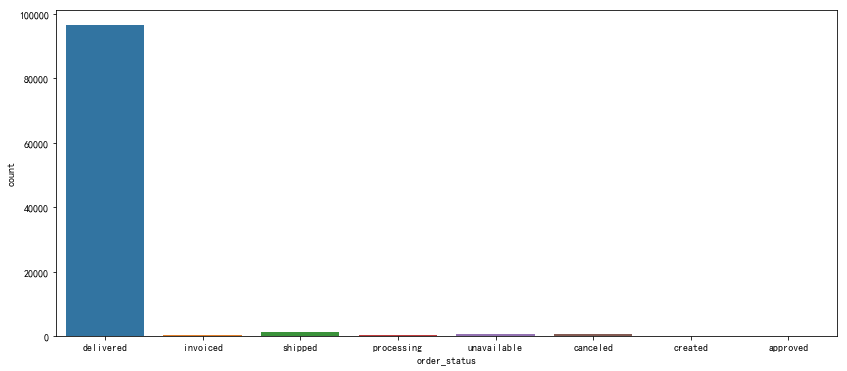

In [24]:

df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(x='order_status',data=df_orders,ax=ax)
plt.show()

In [25]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
df_orders.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [26]:
data_order=df_orders.groupby(by='order_status').count().sort_values(by=['order_id'], ascending=False)[['order_id']]
data_order

,order_id
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


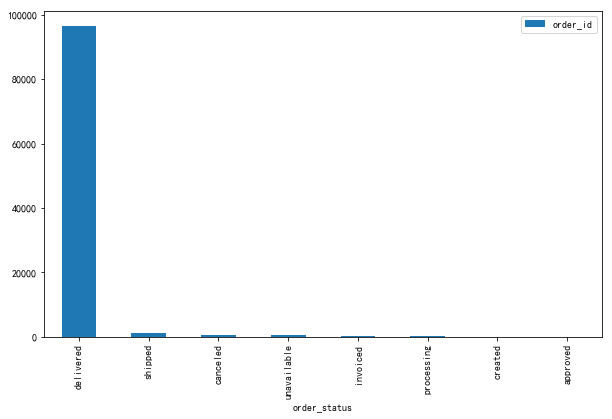

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
data_order.plot(kind='bar',ax=ax)
plt.show()

从时间来看电子商务的发展趋势

In [28]:
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


1. 巴西的电子商务有什么增长趋势吗?
2. 巴西顾客倾向于在星期几网上购物?
3.巴西顾客通常什么时候购物(黎明、早晨、下午还是晚上)?

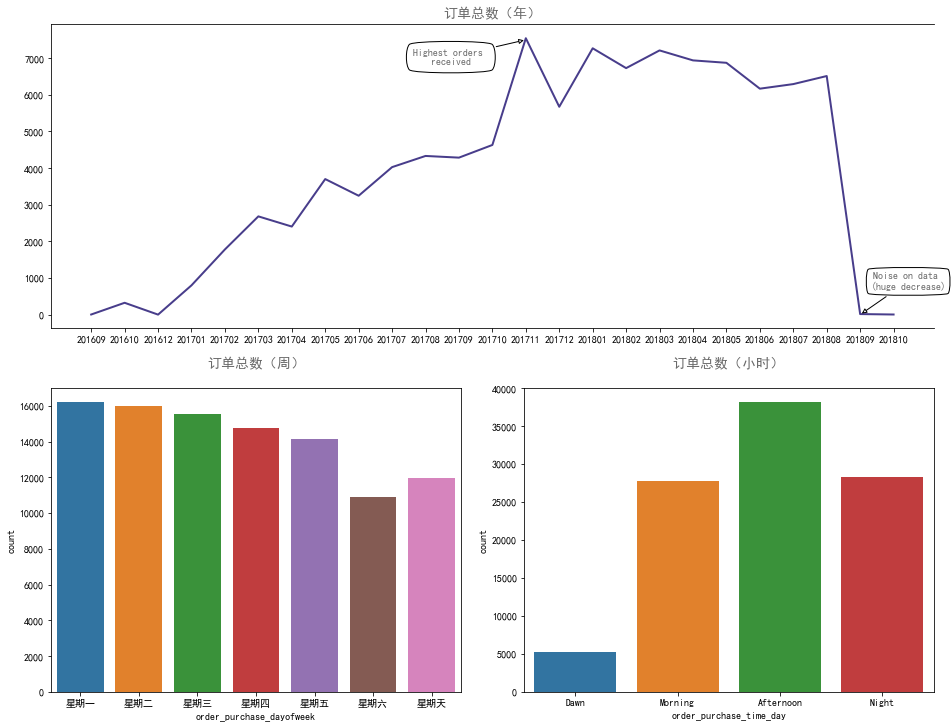

In [29]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.spines['right'].set_visible(False) 

ax1.set_title('订单总数（年）', size=14, color='dimgrey')

sns.countplot( x='order_purchase_dayofweek',data=df_orders, ax=ax2)
weekday_label = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期天']
ax2.set_xticklabels(weekday_label)
ax2.set_title('订单总数（周）', size=14, color='dimgrey', pad=20)

sns.countplot(x='order_purchase_time_day',data=df_orders,ax=ax3)

ax3.set_title('订单总数（小时）', size=14, color='dimgrey', pad=20)

plt.show()

由上面的图表我们可以得出结论:
随着时间的推移，巴西的电子商务确实有一个增长的趋势。我们可以看到一些季节性的高峰在特定的月份，但总的来说，我们可以清楚地看到，顾客比以前更倾向于在网上购物。
周一是巴西顾客最喜欢的一天，他们往往会在下午买更多的东西。


2017vs 2018订单量的比较

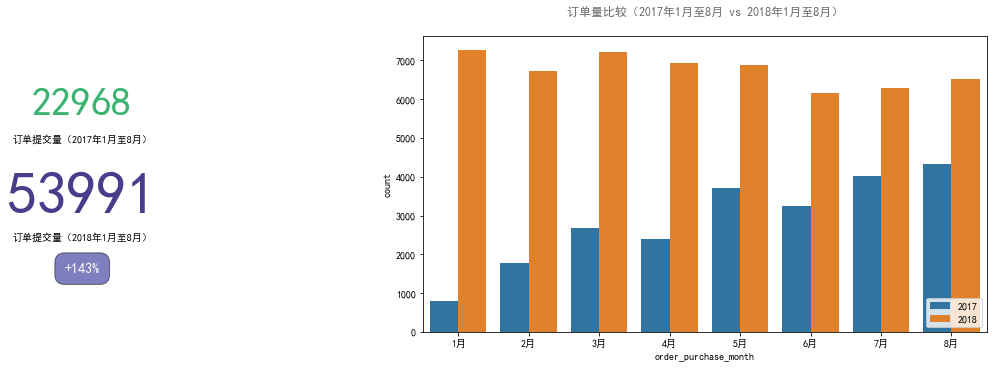

In [30]:
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, '订单提交量（2017年1月至8月）', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, '订单提交量（2018年1月至8月）', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')
sns.countplot( x='order_purchase_month', data=df_orders_compare,hue='order_purchase_year', ax=ax2)
month_label = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月']
ax2.set_xticklabels(month_label)
ax2.set_title('订单量比较（2017年1月至8月 vs 2018年1月至8月）', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

从地理位置来看订单情况

In [31]:
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
# r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
# content = [c['UF'] for c in json.loads(r.text)]
# br_info = pd.DataFrame(content)
# br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
# br_info.drop('regiao', axis=1, inplace=True)
# br_info.drop_duplicates(inplace=True)
# geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# #it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
# geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
# #It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
# geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
# #It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
# geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
# geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()
# df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
# df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
#                                         right_on='geolocation_zip_code_prefix')
df1=df_orders_items
# # df1.to_excel('巴西地理位置.xlsx')
# df1.head()

从区域，城市，状态看顾客订单分布

In [32]:

df_orders_filt = df1[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]
# df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
# df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
# df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
# df_regions_group.reset_index(drop=True, inplace=True)
# df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
#                                        as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
# df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
# df_cities_group = df_cities_group.iloc[:10, :]
# df_state_group=df1.groupby('customer_state').count()
# df_state_group=df_state_group.sort_values(by='order_id').reset_index(drop=False)
# df_state_group = df_state_group.loc[:9, :]
# df_region_1=df_regions_group[df_regions_group['region']=='Centro-Oeste']
# df_region_1=df_region_1['order_count']

# df_region_2=df_regions_group[df_regions_group['region']=='Nordeste']
# df_region_2=df_region_2['order_count']

# df_region_3=df_regions_group[df_regions_group['region']=='Norte']
# df_region_3=df_region_3['order_count']

# df_region_4=df_regions_group[df_regions_group['region']=='Sudeste']
# df_region_4=df_region_4['order_count']

# df_region_5=df_regions_group[df_regions_group['region']=='Sul']
# df_region_5=df_region_5['order_count']


In [33]:
# fig = plt.figure(constrained_layout=True, figsize=(18, 8))
# gs = GridSpec(2, 2, figure=fig)
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[:, 1])

# x=df_regions_group['month'].drop_duplicates()
# y1=df_region_1
# y2=df_region_2
# y3=df_region_3
# y4=df_region_4
# y5=df_region_5

# ax1.plot(x, y1, '.-', label='Centro-Oeste')
# ax1.plot(x,y2, '.-', label='Nordeste')
# ax1.plot(x, y3, '.-', label='Norte')
# ax1.plot(x, y4, '.-', label='Sudeste')
# ax1.plot(x, y5, '.-', label='Sul')
# ax1.set_title('订单分布(按区域)',size=12)
# ax1.legend()

    
# sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
# ax2.spines['right'].set_visible(False) 
# ax2.set_title('订单分布(按城市)', size=12, color='dimgrey')
# ax2.set_ylabel('')

# df_state_group.plot.barh(x='customer_state',y='order_id',ax=ax3,title='订单分布(按顾客状态)',color='indigo')

# plt.show()


In [34]:
# df_regions_group.pivot_table(index=['region'],values='order_count',columns='month', margins=True)
# df_cities_group
# df_state_group


In [35]:
# 热力图
# 顾客分布（按地理位置）
# import folium
# from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

# lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
# longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
# locations = list(zip(lats, longs))
# map1 = folium.Map(location=[-15, -50], zoom_start=4.0)
# FastMarkerCluster(data=locations).add_to(map1)
# map1

In [114]:
df_orders_items.query('order_purchase_year == 2018').head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.9,19.22
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.9,8.72
13,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18,e97109680b052ee858d93a539597bba7,35400,ouro preto,MG,2018,6,Jun,201806,20180607,7,3,Thu,10,Morning,1.0,72a97c271b2e429974398f46b93ae530,094ced053e257ae8cae57205592d6712,2018-06-18 03:13:12,31.9,18.23
14,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,e2dfa3127fedbbca9707b36304996dab,4812,sao paulo,SP,2018,7,Jul,201807,20180725,25,2,Wed,17,Afternoon,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.9,12.80


销售额

In [37]:
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'})
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


In [38]:
# df_month_aggreg.info()

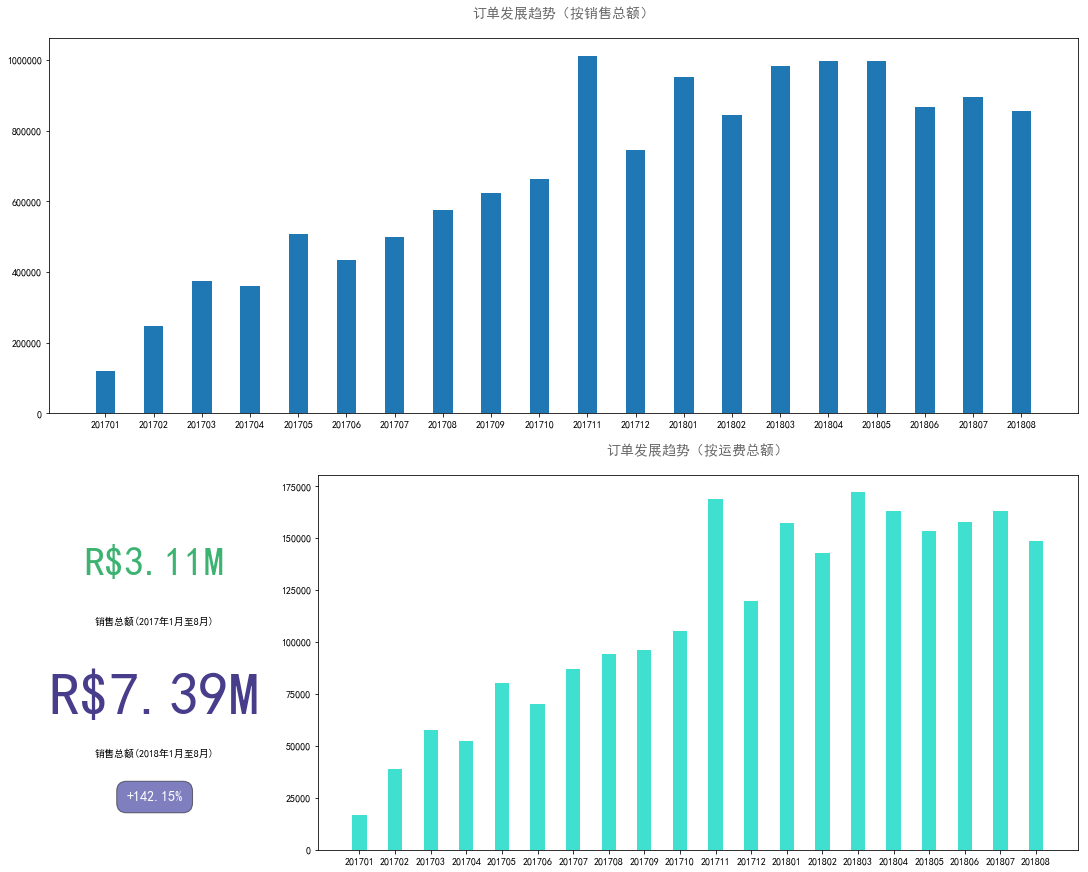

In [66]:
fig = plt.figure(constrained_layout=True, figsize=(15, 12))
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])
ax1.bar(df_month_aggreg['order_purchase_year_month'], df_month_aggreg['price'],0.4)
 
ax1.set_title('订单发展趋势（按销售总额）', size=14, color='dimgrey', pad=20)
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)

ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, '销售总额(2017年1月至8月)', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, '销售总额(2018年1月至8月)', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

ax3.bar(df_month_aggreg['order_purchase_year_month'], df_month_aggreg['freight_value'],0.4,color='turquoise')
ax3.set_title('订单发展趋势（按运费总额）', size=14, color='dimgrey', pad=20)

plt.show()


In [70]:
# sold_2018

7385905.800000223

总销售额(价格总和)是在巴西各州的分布

In [77]:
df_sales_compare['customer_state']=df_orders_filt['customer_state']
df_sales_compare

E:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order,customer_state
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586,SP
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308,BA
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432,GO
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223,RN
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778,SP
5,2017,201706,3611,433038.60,69924.44,119.922071,19.364287,PR
6,2017,201707,4576,498031.48,86940.14,108.835551,18.999156,RS
7,2017,201708,4948,573971.68,94232.92,116.000744,19.044648,RJ
12,2018,201801,8257,950030.36,157271.53,115.057571,19.047055,SP
13,2018,201802,7706,844178.71,142730.25,109.548236,18.521963,MG


In [85]:
#  df_sales_compare.query('customer_state ==["BA"]')['price'].sum()


247303.01999999527

In [104]:
d2=df_sales_compare['price_per_order']
d3=df_sales_compare['price']


0     124.547484
1     123.775285
2     123.099079
3     133.454664
4     121.185618
5     119.922071
6     108.835551
7     116.000744
12    115.057571
13    109.548236
14    119.322019
15    124.893202
16    125.427021
17    122.106466
18    125.932671
19    116.952152
Name: price_per_order, dtype: float64

In [106]:
df_price_per=df_sales_compare.groupby(by='customer_state').agg({'price_per_order':np.sum})
df_price_per=df_price_per.sort_values('price_per_order',ascending=False)
df_price_per

,price_per_order
customer_state,
SP,721.958046
GO,248.526100
RJ,238.107210
RN,133.454664
SC,125.932671
BA,123.775285
PR,119.922071
MG,109.548236
RS,108.835551


In [108]:
df_price=df_sales_compare.groupby(by='customer_state').agg({'price':np.sum})
df_price=df_price.sort_values('price',ascending=False)
df_price

,price
customer_state,
SP,4410961.89
RJ,1439095.99
GO,1370861.98
SC,895507.22
MG,844178.71
RS,498031.48
PR,433038.60
RN,359927.23
BA,247303.02


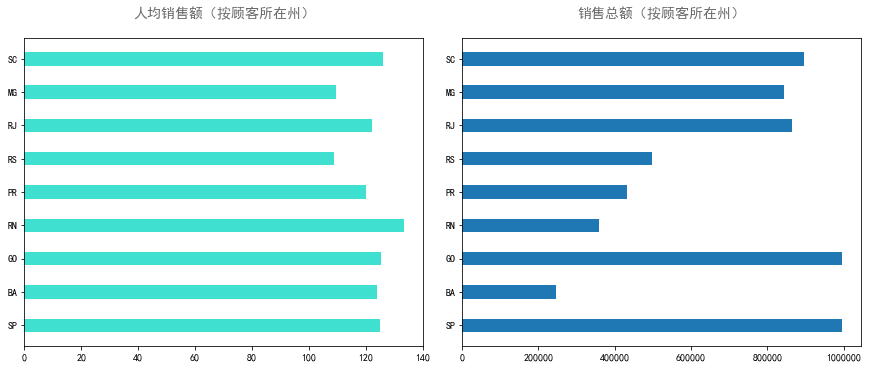

In [113]:
fig = plt.figure(constrained_layout=True, figsize=(12, 5))
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
y1=df_sales_compare['customer_state']
x1=d2
ax1.barh(y1, x1,0.4,color='turquoise')
ax1.set_title('人均销售额（按顾客所在州）', size=14, color='dimgrey', pad=20)
y2=df_sales_compare['customer_state']
x2=d3
ax2.barh(y2,x2,0.4)
ax2.set_title('销售总额（按顾客所在州）', size=14, color='dimgrey', pad=20)
plt.show()


可知：SP是具有商业价值的周，销售总额排第一；人均销售额排第一

In [45]:
d4=df_orders_filt.groupby('customer_state').agg({'freight_value':np.mean}).reset_index(drop=False)
d5=df_orders_filt.groupby('customer_state').agg({'freight_value':np.sum}).reset_index(drop=False)
d4.head()

,customer_state,freight_value
0,AC,40.073370
1,AL,35.898597
2,AM,33.205394
3,AP,34.006098
4,BA,26.365057


In [46]:
d4=d4.sort_values(['freight_value']).head(10)
d4

,customer_state,freight_value
25,SP,15.146922
17,PR,20.555599
10,MG,20.643997
18,RJ,20.964484
6,DF,21.046355
23,SC,21.475034
22,RS,21.734803
7,ES,22.031639
8,GO,22.771914
11,MS,23.374884


In [47]:
d5=d5.sort_values(['freight_value']).head(10)
d5

,customer_state,freight_value
21,RR,2142.53
3,AP,2788.50
0,AC,3686.75
2,AM,5478.89
20,RO,11417.38
26,TO,11732.68
24,SE,14051.00
1,AL,15867.18
19,RN,18707.45
11,MS,19144.03


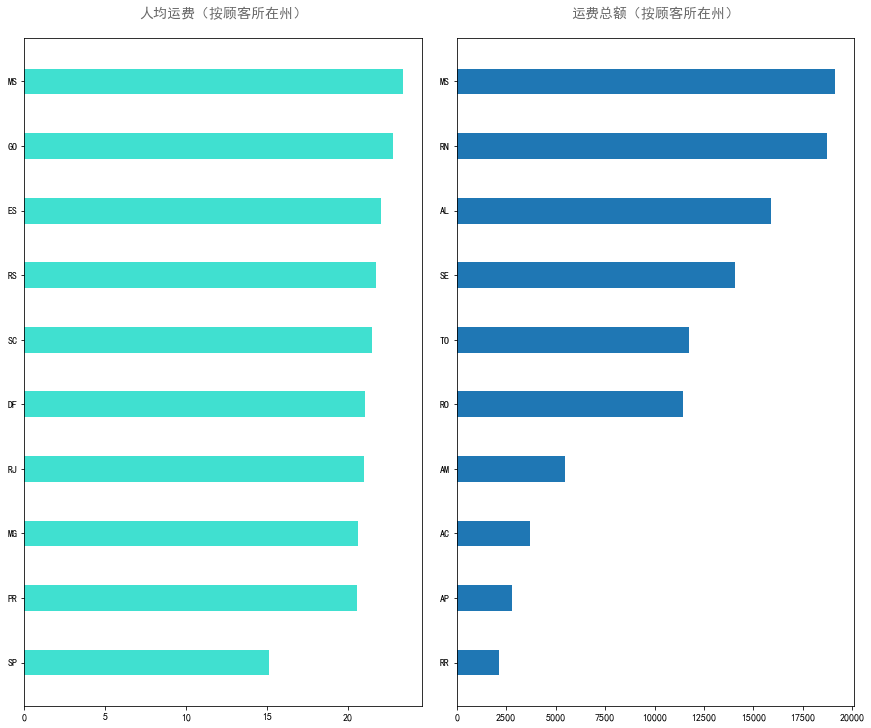

In [48]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
y1=d4['customer_state']
x1=d4['freight_value']
ax1.barh(y1, x1,0.4,color='turquoise')
ax1.set_title('人均运费（按顾客所在州）', size=14, color='dimgrey', pad=20)
y2=d5['customer_state']
x2=d5['freight_value']
ax2.barh(y2,x2,0.4)
ax2.set_title('运费总额（按顾客所在州）', size=14, color='dimgrey', pad=20)
plt.show()

可知：MS（南马托格罗索州），GO（戈亚斯州），ES（圣埃斯皮里图州）三个州的人均运费排名前三，市民在运费上花的钱比较多。但这三个州并不在销售总额前十的排名里面。如若提升这三个州的销售额，可以考虑补贴运费的促销手段

从时间维度来分析

In [49]:
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']


In [50]:

df_orders_filt['time_to_delivery'] = pd.to_datetime(delivered.dropna())-(purchasing.dropna())
df_orders_filt['time_to_delivery']=df_orders_filt['time_to_delivery'].dt.days


In [51]:
df_orders_filt['diff_estimated_delivery'] =pd.to_datetime(delivered.dropna())-estimated.dropna()
df_orders_filt['diff_estimated_delivery']=np.abs(df_orders_filt['diff_estimated_delivery'].dt.days)


In [116]:
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery')
states_time_to_delivery.head()

,customer_state,time_to_delivery
25,SP,8.234595
17,PR,11.465563
10,MG,11.491769
6,DF,12.464423
23,SC,14.495593


In [53]:
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery',ascending=False)
states_estimated_delivery.head()


,customer_state,diff_estimated_delivery
21,RR,25.533333
3,AP,25.530864
0,AC,22.208791
2,AM,21.429448
20,RO,20.560440


In [54]:
states_freight_paid.head()

,customer_state,freight_value
21,RR,43.725102
14,PB,42.753561
20,RO,41.069712
0,AC,40.073370
16,PI,39.153623


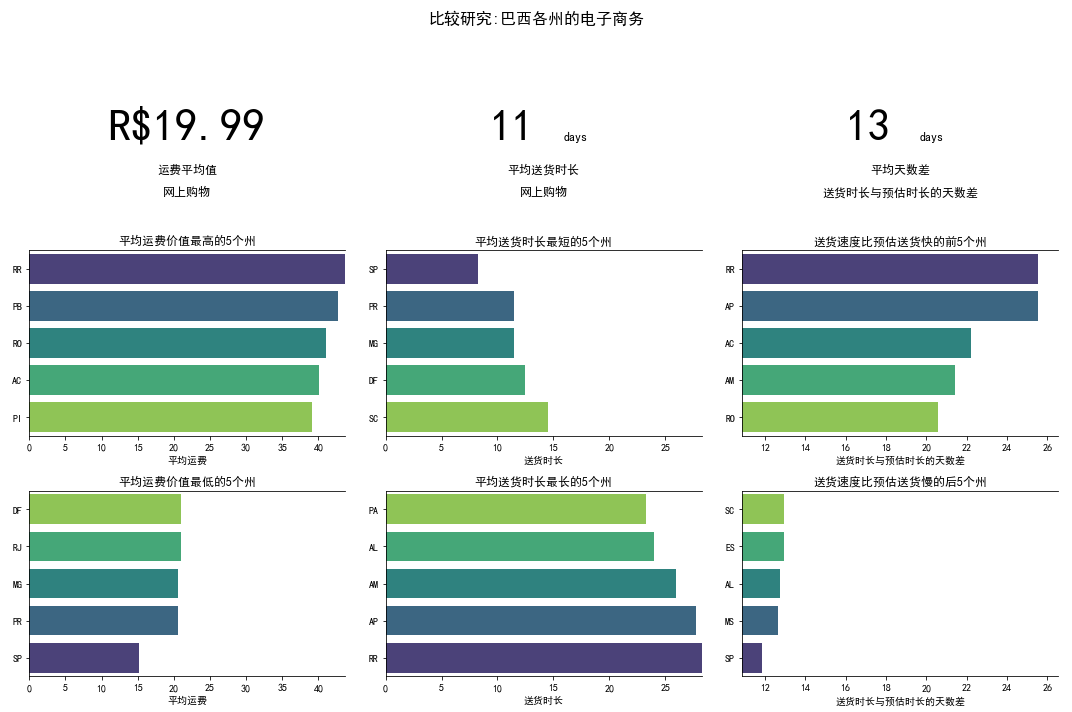

In [55]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('平均运费价值最高的5个州', size=12, color='black')
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='viridis_r')
axs[2, 0].set_title('平均运费价值最低的5个州', size=12, color='black')
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('平均运费')
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    ax.spines['right'].set_visible(False) 
    ax.set_ylabel('')
axs[0, 0].text(0.50, 0.30, f'R${round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, '运费平均值', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, '网上购物', fontsize=12, ha='center')
axs[0, 0].axis('off')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('平均送货时长最短的5个州', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('平均送货时长最长的5个州', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('送货时长')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    ax.spines['right'].set_visible(False) 
    ax.set_ylabel('')
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.60, 0.30, 'days', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, '平均送货时长', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, '网上购物', fontsize=12, ha='center')
axs[0, 1].axis('off')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[1, 2], palette='viridis')
axs[1, 2].set_title('送货速度比预估送货快的前5个州', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[2, 2], palette='viridis_r')
axs[2, 2].set_title('送货速度比预估送货慢的后5个州', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('送货时长与预估时长的天数差')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    ax.spines['right'].set_visible(False) 
    ax.set_ylabel('')
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.60, 0.30, 'days', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, '平均天数差', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, '送货时长与预估时长的天数差', fontsize=12, ha='center')
axs[0, 2].axis('off') 
plt.suptitle('比较研究:巴西各州的电子商务', size=16)
plt.tight_layout()
plt.show()

从付款方式来看：

In [56]:
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')
df_orders_pay.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,13.0,6.0,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,9.0,18.0,1,credit_card,3,179.12


In [57]:
label_names=df_orders_pay['payment_type'].value_counts().index
label_names

Index(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'], dtype='object')

In [58]:
df_payment_type=df_orders_pay.groupby('payment_type').count().reset_index(drop=False)
df_payment_type

,payment_type,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_installments,payment_value
0,boleto,22961,22961,22961,22961,22932,22530,22301,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22961,22796,22796,22796,22796,22796,22796,22301,22301,22961,22961,22961
1,credit_card,86985,86985,86985,86985,86932,85613,84642,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86985,86479,86479,86479,86479,86479,86479,84642,84642,86985,86985,86985
2,debit_card,1696,1696,1696,1696,1696,1675,1651,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1696,1689,1689,1689,1689,1689,1689,1651,1651,1696,1696,1696
3,not_defined,2,2,2,2,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,2,2,2
4,voucher,6365,6365,6365,6365,6298,6189,6103,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6365,6251,6251,6251,6251,6251,6251,6103,6103,6365,6365,6365


In [59]:

# df_boleto=df_payment_type[['order_id']].iat[0,0]
# df_credit_card=df_payment_type[['order_id']].iat[1,0]
# df_debit_card=df_payment_type[['order_id']].iat[2,0]
# df_not_defined=df_payment_type[['order_id']].iat[3,0]
# df_voucher=df_payment_type[['order_id']].iat[4,0]

In [60]:
sum_value=np.sum(df_payment_type[['order_id']])
sum_value

order_id    118009
dtype: int64

In [61]:
df_boleto=(df_payment_type[['order_id']].iat[0,0])/sum_value
df_credit_card=(df_payment_type[['order_id']].iat[1,0])/sum_value
df_debit_card=(df_payment_type[['order_id']].iat[2,0])/sum_value
df_not_defined=(df_payment_type[['order_id']].iat[3,0])/sum_value
df_voucher=df_payment_type[['order_id']].iat[4,0]/sum_value
df_debit_card

order_id    0.014372
dtype: float64

In [62]:
df_orders_pay['payment_type'].value_counts()

credit_card    86985
boleto         22961
voucher         6365
debit_card      1696
not_defined        2
Name: payment_type, dtype: int64

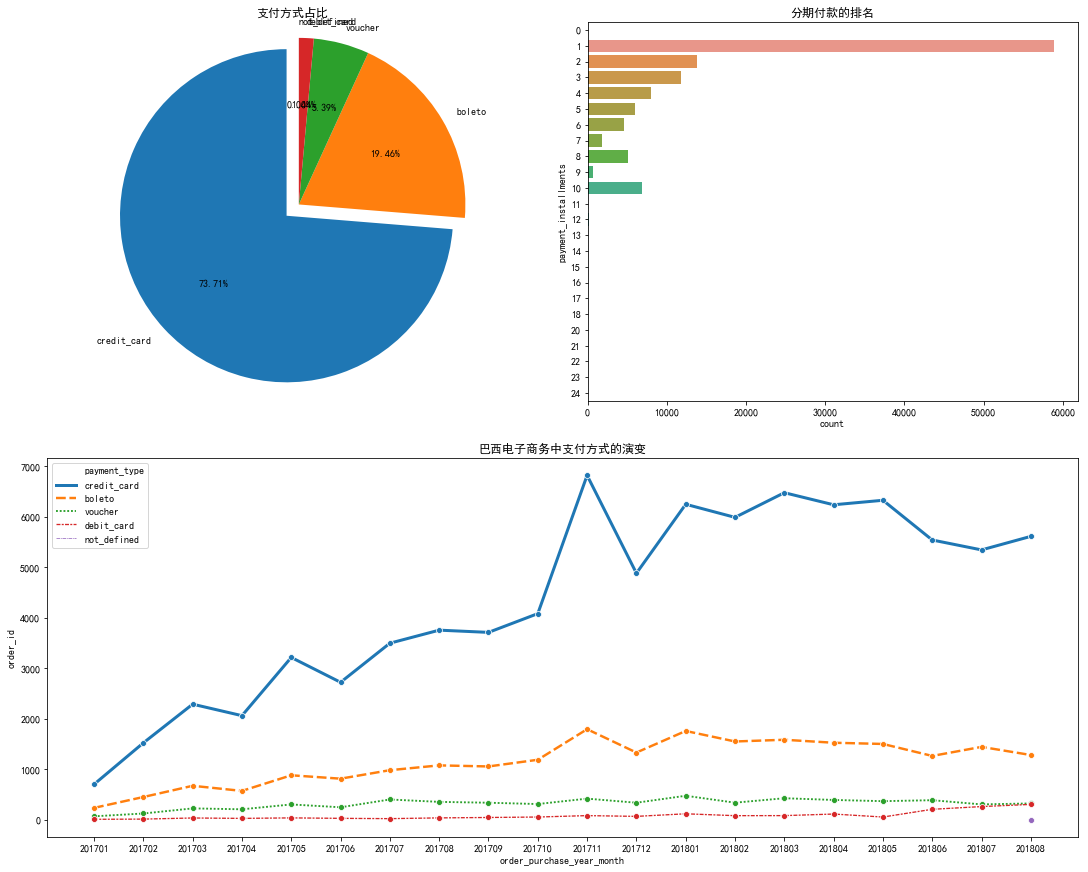

In [63]:

fig = plt.figure(constrained_layout=True, figsize=(15, 12))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
data=[86985,22961,6365,1696,2]
labels = ['credit_card','boleto','voucher','debit_card','not_defined']
explode=(0.1,0,0,0,0)
ax1.pie(data,labels=labels,explode=explode,startangle=90,autopct='%1.2f%%')
ax1.axis("equal")
ax1.set_title('支付方式占比', size=12)
sns.countplot(data=df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('分期付款的排名', size=12)
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', marker='o')
ax.spines['right'].set_visible(False) 
ax3.set_title('巴西电子商务中支付方式的演变',size=12)
plt.show()

从折线图中我们可以看出，在巴西的电子商务中，信用卡支付占据了很大的地位。另一方面，借记卡支付自201805以来呈现出增长趋势，这对投资者来说是一个改善此类支付服务的好机会。
从上面的柱状图中，我们可以看到巴西客户是如何支付订单的:他们大部分是一次性付款一次

从客户维度来分析

In [64]:
df_orders_pay.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,13.0,6.0,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,9.0,18.0,1,credit_card,3,179.12


In [65]:
years = df_orders_pay.order_purchase_year.unique()
print(years)
for year in years:
    sorteddata = df_orders_pay[df_orders_pay.order_purchase_year==year].sort_values(by='payment_value',ascending=False)
    person = sorteddata.customer_id.iloc[0]
    payment = sorteddata.payment_value.iloc[0]
    print("在 %d年 %s 购物最多的顾客是 %8.1f"%(year,person,payment))

[2017 2018]
在 2017年 1617b1357756262bfa56ab541c47bc16 购物最多的顾客是  13664.1
在 2018年 ec5b2ba62e574342386871631fafd3fc 购物最多的顾客是   7274.9


预测总销售额

In [195]:
df_orders_pre=df_orders_pay.groupby('order_purchase_date').agg({'price':np.sum}).reset_index(drop=False)
df_orders_pre['order_purchase_date']=df_orders_pre['order_purchase_date'].astype('int64')
df_orders_pre

,order_purchase_date,price
0,20170105,396.90
1,20170106,3460.38
2,20170107,1351.90
3,20170108,709.58
4,20170109,673.79
...,...,...
599,20180827,5418.66
600,20180828,3757.51
601,20180829,1546.04
602,20180830,0.00


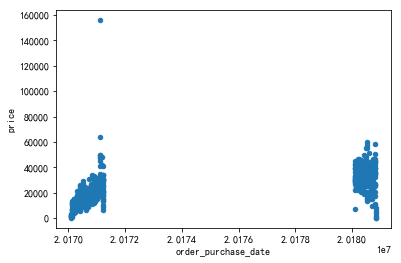

In [196]:
df_orders_pre.plot.scatter(x='order_purchase_date', y='price')

In [200]:
x, y = np.array(df_orders_pre['order_purchase_date']).reshape(-1,1), np.array(df_orders_pre['price']).reshape(-1,1)
# x.shape, y.shape
import sklearn.model_selection as ms
train_x, test_x, train_y, test_y = \
    ms.train_test_split(
        x, y, test_size=0.2, random_state=7)

((604, 1), (604, 1))

线性回归

In [201]:
import sklearn.linear_model as lm
import sklearn.metrics as sm

model = lm.LinearRegression()
model.fit(train_x, train_y)
# 使用测试集测试并评估模型效果
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

0.2346398912296841


岭回归

In [203]:
params = np.arange(1, 604, 50)
for param in params:
    model = lm.Ridge(param)
    model.fit(train_x, train_y)
    # 使用测试集测试并评估模型效果
    pred_test_y = model.predict(test_x)
    print(param,':', sm.r2_score(test_y, pred_test_y))

1 : 0.23463989123632156
51 : 0.23463989156988185
101 : 0.23463989190337387
151 : 0.23463989223690662
201 : 0.23463989257045836
251 : 0.23463989290399334
301 : 0.23463989323752554
351 : 0.23463989357107773
401 : 0.2346398939045875
451 : 0.2346398942380924
501 : 0.23463989457162193
551 : 0.23463989490514303
601 : 0.2346398952387353


多项式回归

In [227]:
import numpy as np
import sklearn.pipeline as pl
import sklearn.preprocessing as sp
import sklearn.linear_model as lm
import sklearn.metrics as sm

model = pl.make_pipeline(
    sp.PolynomialFeatures(3), lm.Ridge(1))
model.fit(train_x, train_y)
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

0.4396318873942564


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.970277e-41
  overwrite_a=True).T


In [226]:
# pred_test_y = model.predict([[20170109]])
# pred_test_y


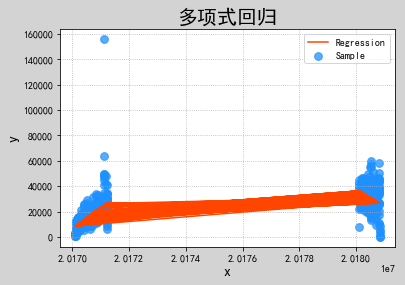

In [229]:
plt.figure('Polynomial Regression', facecolor='lightgray')
plt.title('多项式回归', fontsize=20)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.scatter(x, y, c='dodgerblue', alpha=0.75, s=60, label='Sample')
plt.plot(test_x, pred_test_y, c='orangered', label='Regression')
plt.legend()
plt.show()

X 换维度建模

In [235]:
df_month_aggreg['order_purchase_year_month']=df_month_aggreg['order_purchase_year_month'].astype('int64')
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


In [236]:
x, y = np.array(df_month_aggreg['order_purchase_year_month']).reshape(-1,1), np.array(df_month_aggreg['price']).reshape(-1,1)
# x.shape, y.shape
import sklearn.model_selection as ms
train_x, test_x, train_y, test_y = \
    ms.train_test_split(
        x, y, test_size=0.4, random_state=7)

((20, 1), (20, 1))

In [237]:
import sklearn.linear_model as lm
import sklearn.metrics as sm

model = lm.LinearRegression()
model.fit(train_x, train_y)
# 使用测试集测试并评估模型效果
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

0.2346398912296841


In [238]:
params = np.arange(1, 21, 2)
for param in params:
    model = lm.Ridge(param)
    model.fit(train_x, train_y)
    # 使用测试集测试并评估模型效果
    pred_test_y = model.predict(test_x)
    print(param,':', sm.r2_score(test_y, pred_test_y))

1 : 0.23463989123632156
3 : 0.23463989124967832
5 : 0.23463989126301754
7 : 0.23463989127636908
9 : 0.2346398912896973
11 : 0.23463989130305118
13 : 0.23463989131638818
15 : 0.2346398913297586
17 : 0.23463989134307228
19 : 0.23463989135640173


In [239]:
import numpy as np
import sklearn.pipeline as pl
import sklearn.preprocessing as sp
import sklearn.linear_model as lm
import sklearn.metrics as sm

model = pl.make_pipeline(
    sp.PolynomialFeatures(3), lm.Ridge(1))
model.fit(train_x, train_y)
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

0.4396318873942564


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.970277e-41
  overwrite_a=True).T


优质客户建模

In [241]:
df_orders_pay.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,8.0,8.0,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,13.0,6.0,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,9.0,18.0,1,credit_card,3,179.12


In [263]:

df_customer=df_orders_pay.loc[(df_orders_pay["order_purchase_year_month"] == "201808")]
df_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_type,payment_installments,payment_value
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.9,19.22,9.0,18.0,1,credit_card,3,179.12
30,f3e7c359154d965827355f39d6b1fdac,62b423aab58096ca514ba6aa06be2f98,delivered,2018-08-09 11:44:40,2018-08-10 03:24:51,2018-08-10 12:29:00,2018-08-13 18:24:27,2018-08-17,9c9242ad7f1b52d926ea76778e1c0c57,18052,sorocaba,SP,2018,8,Aug,201808,20180809,9,3,Thu,11,Morning,1.0,e99d69efe684efaa643f99805f7c81bc,55c26bcb609f480eb7868594245febb5,2018-08-14 03:24:51,89.9,14.21,4.0,4.0,1,boleto,1,104.11
50,d22e9fa5731b9e30e8b27afcdc2f8563,756fb9391752dad934e0fe3733378e57,delivered,2018-08-04 23:25:30,2018-08-04 23:35:13,2018-08-06 15:03:00,2018-08-13 23:34:42,2018-09-13,394b2ce444baae9ae609f5d32000de0f,47850,luis eduardo magalhaes,BA,2018,8,Aug,201808,20180804,4,5,Sat,23,Night,1.0,f410090aec61f7c73748ca894286edcd,980640c45d7a4635885491d077167e4d,2018-08-07 23:35:13,99.0,22.62,9.0,31.0,1,debit_card,1,121.62
70,f346ad4ee8f630e5e4ddaf862a34e6dd,dd5095632e3953fc0947b8ab5176b0be,delivered,2018-08-05 13:09:48,2018-08-05 13:24:34,2018-08-06 13:41:00,2018-08-10 18:35:40,2018-08-15,da45a9a1df408c39f013b9b0b505042c,70680,brasilia,DF,2018,8,Aug,201808,20180805,5,6,Sun,13,Afternoon,1.0,4ce99ff9dcb7821acd8e599d5d4a6531,70125af26c2d6d4ef401a1d02ae7701f,2018-08-07 13:24:34,39.9,13.76,5.0,5.0,1,credit_card,1,53.66
98,6d25592267349b322799e2beb687871e,5bb39c890c91b1d26801aa19a9336eac,delivered,2018-08-26 22:04:34,2018-08-28 04:10:18,2018-08-28 12:56:00,2018-08-29 12:40:53,2018-08-30,a71cac9f356cfeb9db35061020806212,2407,sao paulo,SP,2018,8,Aug,201808,20180826,26,6,Sun,22,Night,1.0,c3ba4e8d3cb30049213b682e751e9d00,6560211a19b47992c3666cc44a7e94c0,2018-08-30 04:10:18,93.0,7.91,2.0,1.0,1,boleto,1,201.82


In [293]:
df_customer_1=df_customer.pivot_table(index=['customer_id','customer_state'],values=['price','freight_value']).reset_index(drop=False)
df_customer_1

,customer_id,customer_state,freight_value,price
0,000598caf2ef4117407665ac33275130,MG,148.71,1107.00
1,001df1ee5c36767aa607001ab1a13a06,SP,12.87,29.99
2,002554bdf9eb99618d8189c3a89fdd52,SC,15.08,229.00
3,0026955706fd4e2fa997f3f4c18d485a,SP,22.00,99.90
4,002ebb669a34b9e79c88efc755e95322,RJ,23.57,110.00
...,...,...,...,...
6447,ff9ec39d2bb09243f0139f792ad1ec7b,SC,18.37,38.00
6448,ffb3857a7f2f2945434d57e00d0a97a7,MG,18.89,112.49
6449,ffb5eaca500a57b7dd52256fcfc82e12,RS,18.63,75.00
6450,ffe1eab23bff108bf37c973b05d4e9ba,RS,18.66,79.99


In [294]:
df_customer_2=df_customer_1.loc[(len(df_customer_1['customer_id'])>3) & (df_customer_1['price']>= 1500)]
df_customer_2

,customer_id,customer_state,freight_value,price
390,0ef4273145d74465c180b6a9fbb9799b,SC,110.61,1788.00
497,13c520253ccaf41623e063d5e81c4d82,SP,33.15,2150.00
681,1afc82cd60e303ef09b4ef9837c9505c,SP,113.45,4399.87
1063,2b5734a6ed90ad9c1ae03b178a28d7e7,GO,86.79,2029.00
1069,2b7ae7a532ff538ce88f6bfdd2cb564c,PR,69.20,2350.00
1152,2e9ae3e10bcfcc16fe0eedc2ac5f9f6a,SP,27.42,2160.00
1344,3696afd6fae4a1f36fcbc3db8f3d6640,SP,174.45,2338.08
1615,415c13b4489f9e0714a91d93d347f924,GO,30.56,1623.90
1739,466dcf5fcdc7c7a8a4bfebc7ce59b281,SP,26.99,1988.00
1977,502e8addaeba926b9c154da9f3bbbecf,RN,39.02,1750.00


In [295]:
df_customer_2['target']=np.zeros((26,1))
df_customer_2.head()

E:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_id,customer_state,freight_value,price,target
390,0ef4273145d74465c180b6a9fbb9799b,SC,110.61,1788.00,0.0
497,13c520253ccaf41623e063d5e81c4d82,SP,33.15,2150.00,0.0
681,1afc82cd60e303ef09b4ef9837c9505c,SP,113.45,4399.87,0.0
1063,2b5734a6ed90ad9c1ae03b178a28d7e7,GO,86.79,2029.00,0.0
1069,2b7ae7a532ff538ce88f6bfdd2cb564c,PR,69.20,2350.00,0.0


In [296]:
df_sample=df_customer_1.sample(n=174,replace=False,random_state=None)
df_sample['target']=np.ones((174,1))
df_sample.head()

,customer_id,customer_state,freight_value,price,target
5018,c73b90e099cd1517cb2d1bb468de9a7a,SP,8.73,82.00,1.0
142,0609f5889f00803311ba52e9219c3872,SC,23.18,53.90,1.0
229,095179eaa54b75064120ccdbe350eef3,SP,13.56,129.00,1.0
3651,942caba7c609eaeab06100f10e3fc4d6,SP,7.39,12.35,1.0
1294,349b3b4346e71035d7bff5fd4980f5de,SP,11.50,68.80,1.0


In [303]:
df_customer_sample=pd.concat([df_customer_2,df_sample],axis=0)
df_customer_sample.head()


,customer_id,customer_state,freight_value,price,target
390,0ef4273145d74465c180b6a9fbb9799b,SC,110.61,1788.00,0.0
497,13c520253ccaf41623e063d5e81c4d82,SP,33.15,2150.00,0.0
681,1afc82cd60e303ef09b4ef9837c9505c,SP,113.45,4399.87,0.0
1063,2b5734a6ed90ad9c1ae03b178a28d7e7,GO,86.79,2029.00,0.0
1069,2b7ae7a532ff538ce88f6bfdd2cb564c,PR,69.20,2350.00,0.0


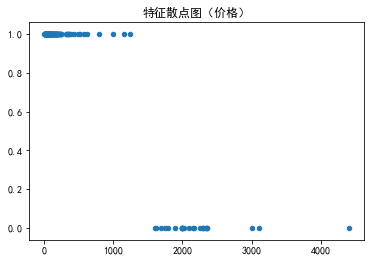

In [306]:

fig = plt.figure()
x=df_customer_sample['price']
y=df_customer_sample['target']
plt.title('特征散点图（价格）')
plt.scatter(x=x, y=y, s=20, marker='o',cmap='brg')
plt.show()

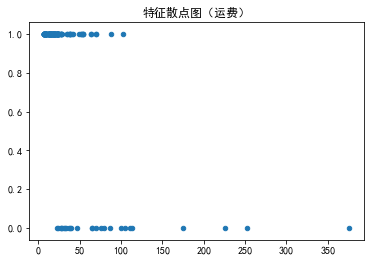

In [307]:
fig = plt.figure()
x=df_customer_sample['freight_value']
y=df_customer_sample['target']
plt.title('特征散点图（运费）')
plt.scatter(x=x, y=y, s=20, marker='o',cmap='brg')
plt.show()

In [359]:
import sklearn.model_selection as ms
import sklearn.linear_model as lm
from sklearn.utils import shuffle
df_customer_sample = shuffle(df_customer_sample)
sub_data = df_customer_sample.sample(n=100,replace=False,random_state=None)
# 整理输入输出集
x,y= sub_data[['price','freight_value']],sub_data['target']

# 拆分训练集测试集
train_x, test_x, train_y, test_y = \
    ms.train_test_split(
        x, y, test_size=0.2, random_state=7)
# 训练模型
model = lm.LogisticRegression(C=1)
model.fit(train_x, train_y)
# 测试模型
pred_test_y = model.predict(test_x)
print(test_y.values)
print(pred_test_y)
print((test_y==pred_test_y).sum() / test_y.size)


[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
0.95


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [360]:

x, y = df_customer_sample[['price','freight_value']], df_customer_sample['target']

# 拆分训练集测试集
train_x, test_x, train_y, test_y = \
    ms.train_test_split(
        x, y, test_size=0.2, random_state=7,
        stratify=y)
# 训练模型
model = lm.LogisticRegression(C=1)

# 做5次交叉验证
scores = ms.cross_val_score(
    model, x, y, cv=5, scoring='accuracy')
print(scores.mean())
scores = ms.cross_val_score(
    model, x, y, cv=5, scoring='precision_weighted')
print(scores.mean())
scores = ms.cross_val_score(
    model, x, y, cv=5, scoring='recall_weighted')
print(scores.mean())
scores = ms.cross_val_score(
    model, x, y, cv=5, scoring='f1_weighted')
print(scores.mean())

0.984993746091307
0.9868172816343547
0.984993746091307
0.9851922399462765


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: Futur

In [361]:
model.fit(train_x, train_y)
# 测试模型
pred_test_y = model.predict(test_x)
print(test_y.values)
print(pred_test_y)
print((test_y==pred_test_y).sum() / test_y.size)

[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
0.975


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


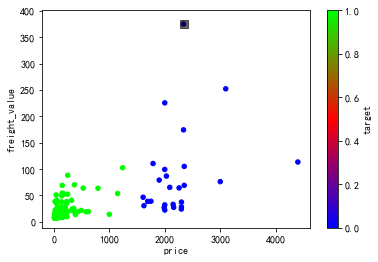

In [365]:
errors = test_x[test_y!=pred_test_y]
ax=df_customer_sample.plot.scatter(
    x='price',y='freight_value', c='target',cmap='brg')
errors.plot.scatter(ax=ax, 
    x='price', y='freight_value',
    c='black', alpha=0.6, s=60, marker='s')

In [366]:
import sklearn.metrics as sm
r = sm.confusion_matrix(test_y, pred_test_y)
print(r)

[[ 4  1]
 [ 0 35]]


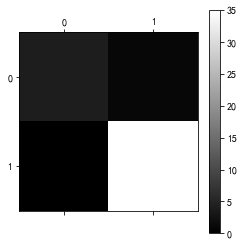

In [367]:
plt.matshow(r, cmap='gray')
plt.colorbar()

In [368]:
r = sm.classification_report(test_y, pred_test_y)
print(r)

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.97      1.00      0.99        35

    accuracy                           0.97        40
   macro avg       0.99      0.90      0.94        40
weighted avg       0.98      0.97      0.97        40

